In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from matplotlib.lines import Line2D
import itertools

In [2]:
from pathlib import Path
Path("holonomic_data").mkdir(parents=True, exist_ok=True)
Path("nonhn_data").mkdir(parents=True, exist_ok=True)
Path("holo_wheel_data").mkdir(parents=True, exist_ok=True)
Path("nh_wheel_data").mkdir(parents=True, exist_ok=True)

In [3]:
class env:
    def __init__(self,obs_x,obs_y,radii,circle_x,circle_y,num_circles,xmin,xmax,ymin,ymax):
        self.obst_x = obs_x
        self.obst_y = obs_y
        self.xlim = (xmin,xmax)
        self.ylim = (ymin,ymax)
        self.radii = radii
        self.circle_x = circle_x
        self.circle_y = circle_y
        self.num_circles = num_circles
    
    def isInside(self,circle_x, circle_y, rad, x, y): # Checking if a point lies in a circle
 
        if ((x - circle_x) * (x - circle_x) + 
            (y - circle_y) * (y - circle_y) <= rad * rad): 
            return True; 
        else: 
            return False; 
        

    def inobstacle(self,x1,y1,x2,y2): #check if edge lies inside obstacle
        c=1 #assume no collision
        obs_num = len(self.obst_x)/4 
        for i in range(1,int(obs_num)+1): #Checking if the edge lies in one of the rectangles
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            for j in range(0,101):
                u=j/100.0
                x=x1*u+x2*(1-u)
                y=y1*u+y2*(1-u)
                if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                    c=0
                    break
            if c==0:
                break
                
        if c==1: # If a collision hasnt occured with a rectangle
            for i in range(self.num_circles):
                x1c = self.circle_x[i]
                y1c = self.circle_y[i]
                r = self.radii[i]
                for j in range(0,101):
                    u=j/100.0
                    x=x1*u+x2*(1-u)
                    y=y1*u+y2*(1-u)
                    if (self.isInside(x1c, y1c, r, x, y)): 
                        c=0
                        break
                if c == 0:
                    break
        return c

    def isfree(self): #check if new node lies inside obstacle
        n= G.number_of_nodes()-1
        (x,y)= (G.x[n], G.y[n]) 
        obs_num = len(self.obst_x)/4 #four vertices for each rectangular obstacle
        for i in range(1,int(obs_num)+1):
            xomin=self.obst_x[4*(i-1)]
            xomax=self.obst_x[4*(i-1)+2]
            yomin=self.obst_y[4*(i-1)]
            yomax=self.obst_y[4*(i-1)+1]
            if (x>=xomin) and (x<=xomax) and (y>=yomin) and (y<=yomax):
                G.remove_node(n)
                return 0
                break
        for i in range(self.num_circles): # For circle
            x1c = self.circle_x[i]
            y1c = self.circle_y[i]
            r = self.radii[i]
            if (self.isInside(x1c, y1c, r, x, y)): 
                G.remove_node(n)
                return 0
                break             
        return 1
                
    def ingoal(self):
        n= G.number_of_nodes()-1
        (x,y)= (G.x[n], G.y[n]) 
        tol = 5
        if (np.linalg.norm(np.array([x-xg,y-yg])**2)<tol):
            return 1
        else:
            return 0


In [74]:
def draw ():
    #draw boundary
    plt.plot([0-2*rbot,0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot],[0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot,0-2*rbot],'k',lw=0.5)

    plt.plot(xg,yg,'g*',markersize=20)
    plt.plot(0,2,'b*',markersize=20)

    num = len(E.obst_x)/4
    for i in range(1,int(num)+1): # Plotting rectangles
        x = E.obst_x[4*(i-1)] +2*rbot
        y = E.obst_y[4*(i-1)]+2*rbot
        width = E.obst_x[4*(i-1)+2] - E.obst_x[4*(i-1)] - 4*rbot
        height = E.obst_y[4*(i-1)+2] - E.obst_y[4*(i-1)] - 4*rbot
        rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
        plt.gca().add_patch(rect)
#         plt.plot([E.obst_x[4*(i-1)],E.obst_x[4*(i-1)+1],E.obst_x[4*(i-1)+2],
#         E.obst_x[4*(i-1)+3],E.obst_x[4*(i-1)]],[E.obst_y[4*(i-1)],E.obst_y[4*(i-1)+1],
#         E.obst_y[4*(i-1)+2],E.obst_y[4*(i-1)+3],E.obst_y[4*(i-1)]],'k',lw=1) 
# Uncomment to viz config space


    for i in range(E.num_circles): #plotting  circles
        circle = plt.Circle((E.circle_x[i],E.circle_y[i]),E.radii[i]-2*rbot, color='r')
        plt.gca().add_patch(circle)
#         circle = plt.Circle((E.circle_x[i],E.circle_y[i]),E.radii[i], facecolor='none',linewidth=1,edgecolor='k')
#         plt.gca().add_patch(circle)
# Uncomment to viz config space
        
    

    G.showtree('0.15')
    #draw path
    G.showpath('bo-')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

## Holonomic

In [79]:
class holonomic_RRT:
    def __init__(self,nstart):
        (x,y,theta0)=nstart
        self.x=[]
        self.y=[]
        self.theta=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        self.theta.append(theta0)
        #first node is the only node whose parent is itself
        self.parent.append(0)

    #get metric value (current metric is euclidean distance)
    def metric(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        px=(x1-x2)**(2)
        py=(y1-y2)**(2)
        metric = (px+py)**(0.5)
        return metric

    def holonomic_kinematics(xdot,ydot,thetadot):
        theta = thetadot*del_t
        w1 = theta
        w2 = theta + 2*np.pi/3
        w3 = theta + 4*np.pi/3
        controls = np.array([[xdot,ydot,thetadot]]).T
        kin_mat = 1/wrad*np.array([[-np.sin(w1),np.cos(w1),rbot],
                                   [-np.sin(w2),np.cos(w2),rbot],
                                   [-np.sin(w3),np.cos(w3),rbot]])
        ang_velos = np.dot(kin_mat,controls)
        wv1 = ang_velos[0][0]*rbot
        wv2 = ang_velos[1][0]*rbot
        wv3 = ang_velos[2][0]*rbot
        return wv1,wv2,wv3
        
        
    #expand a random point
    #calls subroutines to find nearest node and connect it
    def expand (self):
        #add random node
        thetadot = random.uniform(-thetadot_lim,thetadot_lim)
        xdot = random.uniform(vxmin,vxmax)
        ydot = random.uniform(vymin,vymax)
        x = xdot*del_t
        y = ydot*del_t
        theta = thetadot*del_t
#         x = random.uniform (E.xlim[0], E.xlim[1])
#         y = random.uniform (E.ylim[0], E.ylim[1])
        n= self.number_of_nodes() #new node number
        self.add_node(n,x,y,theta)
        if E.isfree()!=0:
            #find nearest node
            nnear = self.near(n)
            #find new node based on step size
            self.step(nnear,n,theta)
            #connect the random node with its nearest node
            self.connect(nnear,n)
            
    #nearest node
    def near(self,n):
        #find a near node
        dmin = self.metric(0,n)
        nnear = 0
        for i in range(0,n):
            if self.metric(i,n) < dmin:
                dmin=self.metric(i,n)
                nnear = i
        return nnear

#step size
    def step(self,nnear,nrand,theta):
        d = self.metric(nnear,nrand)
        if d>dmax:
            u=dmax/d
            (xnear,ynear)= (self.x[nnear],self.y[nnear])
            (xrand,yrand)= (self.x[nrand],self.y[nrand]) 
            (px,py)=(xrand-xnear,yrand-ynear)
            theta_des = math.atan2(py,px)
            (x,y)=(xnear+dmax*math.cos(theta_des),ynear+dmax*math.sin(theta_des))
            self.remove_node(nrand)
            self.add_node(nrand,x,y,theta) #this is a new node between rand and near

#connect two nodes (local planner)
    def connect(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        n= G.number_of_nodes()-1
        #subdivide path into 100 small segments and ensure each segment is collision free
        if E.inobstacle(x1,y1,x2,y2)==0:
            self.remove_node(n2)
        else:
            self.add_edge(n1,n2)


#add node
    def add_node(self,n,x,y,theta):
        self.x.insert(n, x)
        self.y.insert(n, y)
        self.theta.insert(n,theta)

#remove node
    def remove_node(self,n):
        self.x.pop(n)
        self.y.pop(n)
        self.theta.pop(n)

#add edge
    def add_edge(self,parent,child):
        self.parent.insert(child,parent)

#remove node
    def remove_edge(self,n):
        self.parent.pop(n)
#clear
    def clear(self,nstart):
        (x,y)=nstart
        self.x=[]
        self.y=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        #first node is the only node whose parent is itself
        self.parent.append(0)
        
#number of nodes
    def number_of_nodes(self):
        return len(self.x)

#path to goal
    def path_to_goal(self):
        #find goal state
        tol = 5
        for i in range (0,G.number_of_nodes()):
            (x,y)= (self.x[i],self.y[i])
            if (np.linalg.norm(np.array([x-xg,y-yg])**2)<tol):
                print("THE GOAL IS")
#                 print(i)
                print(x,y)
                self.goalstate = i
                break
        #add goal state to and its parent node to the path
        self.path=[]
#         print("WHAT")
#         print(i)
        self.path.append(i)
        newpos=self.parent[i]
        #keep adding parents
        while (newpos!=0):
#             print("check")
            self.path.append(newpos)
            newpos=self.parent[newpos]
        #add start state
        self.path.append(0)

        
    #draw tree
    def showtree(self,k):
        node_num = 0
        for i in range (0,self.number_of_nodes()):
            par=self.parent[i]
            plt.plot([self.x[i],self.x[par]],[self.y[i],self.y[par]],k,lw=0.5)

#             plt.title('Step: %d' %(i+1))
            if (i%5==0 or i==0):
                name = 'holonomic_data/snap%s.png'%str(i)
                plt.gca().set_aspect('equal', adjustable='box')
                plt.savefig(name, dpi = 200)

    #draw path 
    def showpath(self,k):
        n = len(self.path)-1
        start = self.path[n]
        start_w1x = self.x[start]+rbot*np.cos(self.theta[start])
        start_w1y = self.y[start]+rbot*np.sin(self.theta[start])
        start_w2x = self.x[start]+rbot*np.cos(self.theta[start]+2*np.pi/3)
        start_w2y = self.y[start]+rbot*np.sin(self.theta[start]+2*np.pi/3)
        start_w3x = self.x[start]+rbot*np.cos(self.theta[start]+4*np.pi/3)
        start_w3y = self.y[start]+rbot*np.sin(self.theta[start]+4*np.pi/3)
        w1_pos.append((start_w1x,start_w1y))
        w2_pos.append((start_w2x,start_w2y))
        w3_pos.append((start_w3x,start_w3y))
        for i in range (len(self.path)-1):
            n = len(self.path)-1
            n1=self.path[n-i]
            n2=self.path[n-(i+1)]
            x_diff = self.x[n2]-self.x[n1]
            y_diff = self.y[n2]-self.x[n1]
            theta_diff = self.theta[n2]-self.theta[n1]
            xdot = x_diff/del_t
            ydot = y_diff/del_t
            thetadot = theta_diff/del_t
#             vw1,vw2,vw3 = holonomic_kinematics(xdot,ydot,thetadot)
            w1_x = self.x[n2]+rbot*np.cos(self.theta[n2])
            w1_y = self.y[n2]+rbot*np.sin(self.theta[n2])
            w2_x = self.x[n2]+rbot*np.cos(self.theta[n2]+2*np.pi/3)
            w2_y = self.y[n2]+rbot*np.sin(self.theta[n2]+2*np.pi/3)
            w3_x = self.x[n2]+rbot*np.cos(self.theta[n2]+4*np.pi/3)
            w3_y = self.y[n2]+rbot*np.sin(self.theta[n2]+4*np.pi/3)
            centre_pos.append((self.x[n1],self.y[n1]))
            w1_pos.append((w1_x,w1_y))
            w2_pos.append((w2_x,w2_y))
            w3_pos.append((w3_x,w3_y))
            
            plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],k,lw=1,markersize=3)
#             plt.title('Step: %d' %(self.number_of_nodes()))
            name = 'holonomic_data/snap%s.png'%str(i+self.number_of_nodes())
#             plt.show()
            plt.gca().set_aspect('equal', adjustable='box')
            plt.savefig(name, dpi = 200)
#             self.visualize_wheels(w1_pos,w2_pos,w3_pos,centre_pos)

Iter:  0
Iter:  10
Iter:  20
Iter:  30
Iter:  40
Iter:  50
Iter:  60
Iter:  70
Iter:  80
Iter:  90
Iter:  100
Iter:  110
Iter:  120
Iter:  130
Iter:  140
Iter:  150
Iter:  160
Iter:  170
Iter:  180
Iter:  190
Iter:  200
Iter:  210
Iter:  220
Iter:  230
Iter:  240
Iter:  250
Iter:  260
Iter:  270
Iter:  280
Iter:  290
Iter:  300
Iter:  310
Iter:  320
Iter:  330
Iter:  340
Iter:  350
Iter:  360
Iter:  370
Iter:  380
Iter:  390
Iter:  400
Iter:  410
Iter:  420
Iter:  430
Iter:  440
Iter:  450
Iter:  460
Iter:  470
Iter:  480
Iter:  490
Iter:  500
Iter:  510
Iter:  520
Iter:  530
Iter:  540
Iter:  550
Iter:  560
Iter:  570
Iter:  580
Iter:  590
Iter:  600
Iter:  610
Iter:  620
Iter:  630
Iter:  640
Iter:  650
Iter:  660
Iter:  670
Iter:  680
Iter:  690
Iter:  700
Iter:  710
Iter:  720
Iter:  730
Iter:  740
Iter:  750
Iter:  760
Iter:  770
Iter:  780
Iter:  790
Iter:  800
Iter:  810
Iter:  820
Iter:  830
Iter:  840
Iter:  850
Iter:  860
Iter:  870
Iter:  880
Iter:  890
Iter:  900
Iter:  910

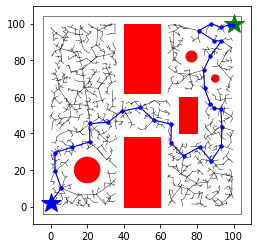

In [81]:
nmax = 6000

#goal region
xg=100
yg=100
epsilon=0
vxmin = vymin = 0
vxmax = xg
vymax= yg
thetadot_lim = np.pi/6
xgmin=xg-epsilon
xgmax=xg+epsilon
ygmin=yg-epsilon
ygmax=yg+epsilon
rbot = 2

#extend step size
dmax = 10
del_t = 1
#start the root of the tree
nstart =(0,2,0) 
n_rect_obst = 3
wrad = 1

#specify vertices for rectangular obstacles (each object has four vertices)
#obstacles known a priori
v_origx= [40,40,60,60,70,70,80,80,40,40,60,60]
v_origy= [62,100,100,62,40,60,60,40, 0,38,38, 0]

centre_pos = []
w1_pos = []
w2_pos = []
w3_pos = []

## Triangular obstacles
X_triangle = np.array([[15,15],[30,15], [20, 40],[80,70],[90,70],[90,90]])

# after padding rectangular obstacles 
vx = [i for i in v_origx]
vy = [i for i in v_origy]
for i in range(n_rect_obst):
    vx[i*4]-=2*rbot
    vx[i*4+1] -=2*rbot
    vx[i*4+2] +=2*rbot
    vx[i*4+3] +=2*rbot
    vy[i*4]-=2*rbot
    vy[i*4+3] -=2*rbot
    vy[i*4+1] +=2*rbot
    vy[i*4+2] +=2*rbot

#create an RRT tree with a start node
G = holonomic_RRT(nstart)

#environment instance
radii = [7+2*rbot,2+2*rbot, 3+2*rbot]
circle_x = [20,90,77]
circle_y = [20,70,82]
num_circles = len(circle_x)
E=env(vx,vy,radii,circle_x,circle_y,num_circles,0,100,0,100)

def main():
#     draw()
    for i in range(0,nmax):
        if i%10==0:
            print("Iter: ",i)
        G.expand()
        
        if E.ingoal()==1:
            print("check")
            break
    G.path_to_goal()
    
    draw()
    
# run main when RRT is called
if __name__ == '__main__':
    main()

In [82]:
def visualize_holo_wheels(w1_pos,w2_pos,w3_pos):
#     print ("I'm here")
    w1_pos_x = [i[0] for i in w1_pos]
    w1_pos_y = [i[1] for i in w1_pos]

    w2_pos_x = [i[0] for i in w2_pos]
    w2_pos_y = [i[1] for i in w2_pos]

    w3_pos_x = [i[0] for i in w3_pos]
    w3_pos_y = [i[1] for i in w3_pos]
    for j in range(len(w1_pos)):
        figure = plt.figure()
        ax = figure.add_subplot(1,1,1)
        plt.plot([0-2*rbot,0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot],[0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot,0-2*rbot],'k',lw=0.5)
        ax.plot(100,100,'g*',markersize=20)
        num = len(E.obst_x)/4
        for i in range(1,int(num)+1): # Plotting rectangles
            x = E.obst_x[4*(i-1)] +2*rbot
            y = E.obst_y[4*(i-1)]+2*rbot
            width = E.obst_x[4*(i-1)+2] - E.obst_x[4*(i-1)] - 4*rbot
            height = E.obst_y[4*(i-1)+2] - E.obst_y[4*(i-1)] - 4*rbot
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)
#             plt.plot([E.obst_x[4*(i-1)],E.obst_x[4*(i-1)+1],E.obst_x[4*(i-1)+2],
#             E.obst_x[4*(i-1)+3],E.obst_x[4*(i-1)]],[E.obst_y[4*(i-1)],E.obst_y[4*(i-1)+1],
#             E.obst_y[4*(i-1)+2],E.obst_y[4*(i-1)+3],E.obst_y[4*(i-1)]],'k',lw=1)
# Uncomment to viz config space

        for i in range(E.num_circles):
            circle = plt.Circle((E.circle_x[i],E.circle_y[i]),E.radii[i]-2*rbot, color='r')
            plt.gca().add_patch(circle)
#             circle = plt.Circle((E.circle_x[i],E.circle_y[i]),E.radii[i], facecolor='none',linewidth=1,edgecolor='k')
#             plt.gca().add_patch(circle)
# Uncomment to viz config space
        ax.plot(w1_pos_x[:j],w1_pos_y[:j],'bo--',markersize=3)
        ax.plot(w2_pos_x[:j],w2_pos_y[:j],'go--',markersize=3)
        ax.plot(w3_pos_x[:j],w3_pos_y[:j],'ko--',markersize=3)

        colors = ['blue', 'green', 'black']
        lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
        labels = ['wheel1', 'wheel2', 'wheel3']
        plt.legend(lines, labels)
        name = 'holo_wheel_data/snap%s.png'%str(j)
        plt.gca().set_aspect('equal', adjustable='box')
        
        plt.savefig(name, dpi = 200)
#         plt.cla()
#         plt.close()
plt.show()

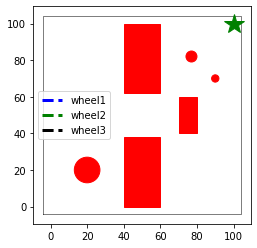

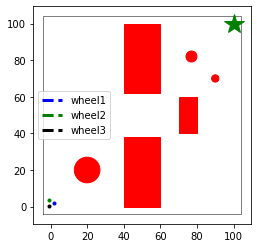

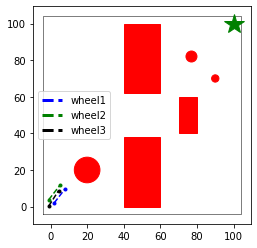

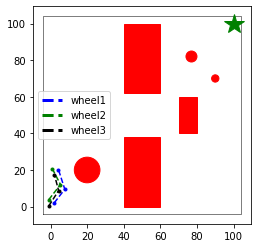

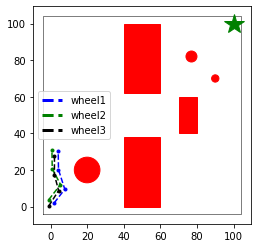

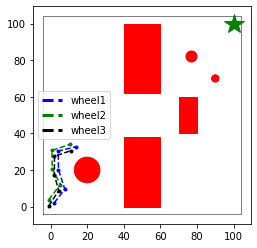

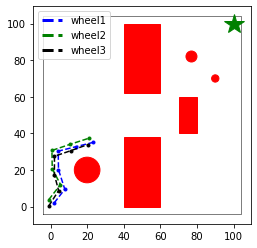

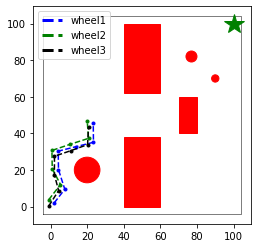

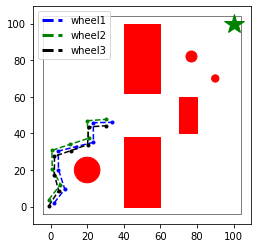

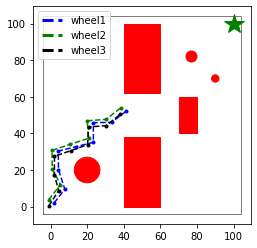

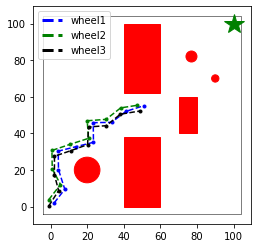

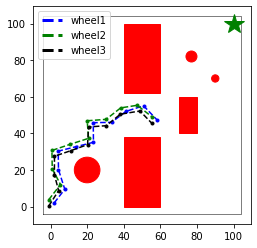

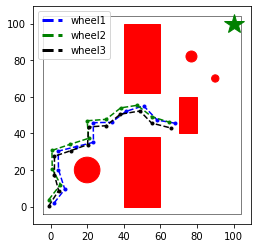

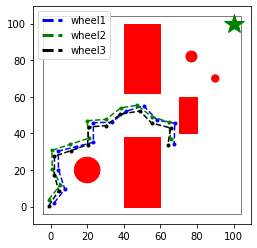

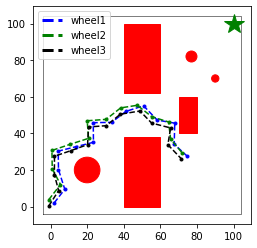

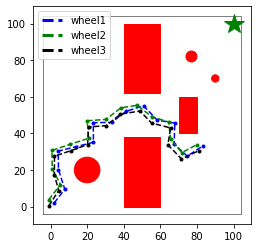

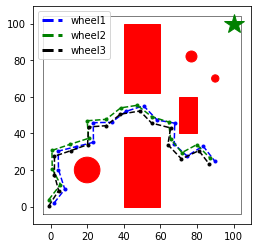

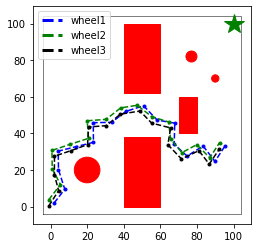

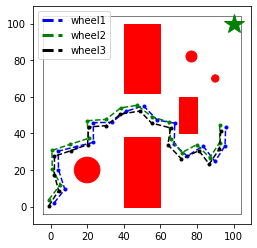

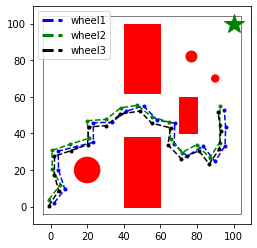

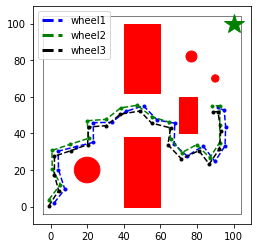

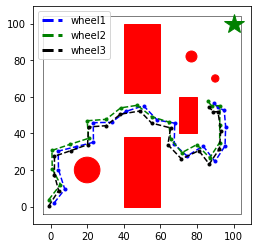

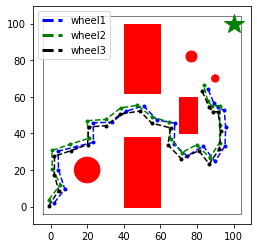

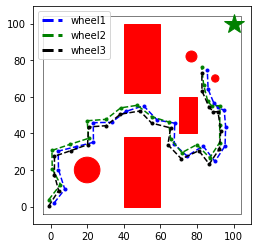

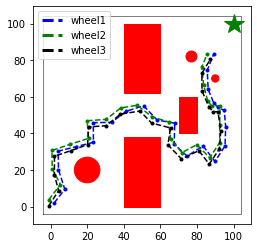

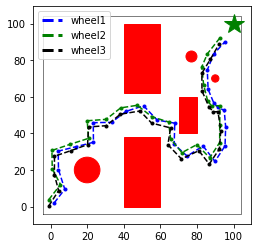

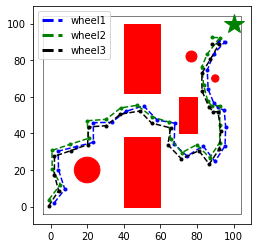

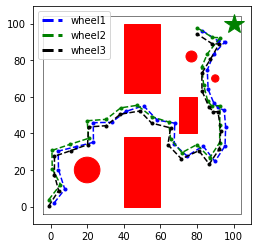

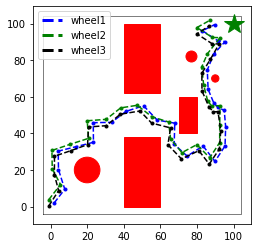

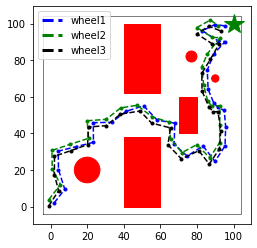

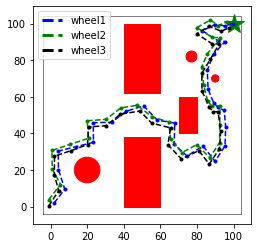

In [83]:
visualize_holo_wheels(w1_pos,w2_pos,w3_pos)

In [62]:
# from moviepy.editor import VideoFileClip, concatenate_videoclips


# clip_1 = VideoFileClip("results/holo_simulation1.mp4")
# clip_2 = VideoFileClip("results/holo_simulation2.mp4")
# final_clip = concatenate_videoclips([clip_1,clip_2])
# final_clip.write_videofile("results/holo_final.mp4")

t:  17%|█▋        | 15/88 [00:00<00:00, 147.71it/s, now=None]

Moviepy - Building video results/holo_final.mp4.
Moviepy - Writing video results/holo_final.mp4



Moviepy - Done !
Moviepy - video ready results/holo_final.mp4


## Non-holonomic RRT

In [31]:
class nonhn_RRT:
    def __init__(self,nstart):
        (x,y,theta0)=nstart
        self.x=[]
        self.y=[]
        self.theta=[]
        self.vc = []
        self.wc = []
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        self.theta.append(theta0)
        self.vc.append(vinit)
        self.wc.append(winit)
        #first node is the only node whose parent is itself
        self.parent.append(0)

    #get metric value (current metric is euclidean distance)
    def metric(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        px=(x1-x2)**(2)
        py=(y1-y2)**(2)
        metric = (px+py)**(0.5)
        return metric
    #expand a random point
    #calls subroutines to find nearest node and connect it
            
    def expand_nh(self):
        #add random node
        x = random.uniform (E.xlim[0], E.xlim[1])
        y = random.uniform (E.ylim[0], E.ylim[1])
        theta = random.uniform(-math.pi, math.pi)
#         theta = random.choice([-math.pi/4, 0, math.pi/4])
        n= self.number_of_nodes() #new node number
        self.add_node(n,x,y,theta,0,0)
        nnear = self.near(n) # Finding the nearest node to the randomly sampled node
        xfinal, yfinal, thetafinal, vbest, wbest = self.nonholonomic_drive(nnear,n)
        if E.xlim[0] <= xfinal <=  E.xlim[1] and E.ylim[0] <= yfinal <= E.ylim[1]:
            self.remove_node(n)
            self.add_node(n,xfinal,yfinal,thetafinal,vbest,wbest)
            if E.isfree()!=0:
                #find new node based on step size
                self.step(nnear,n,theta,vbest,wbest)
                #connect the random node with its nearest node
                self.connect(nnear,n)
        else:
            self.remove_node(n)
    
    def nonholonomic_drive(self,nnear,n):
        x0 = self.x[nnear]
        y0 = self.y[nnear]
        theta0 = self.theta[nnear]
        
        xgoal = self.x[n]
        ygoal = self.y[n]
        thetagoal = self.theta[n]
        
        v, w = [0.5, 6], [-math.pi/10, 0, math.pi/10]
        controls = list(itertools.product(v, w))
        
        max_dist = np.inf
        xfinal = 0
        yfinal = 0
        thetafinal = 0
        vbest = 0
        wbest = 0
        for i in controls:
            vtemp, wtemp = i[0], i[1]
            xnew = x0 + vtemp*del_t*math.cos(theta0 + wtemp*del_t)
            ynew = y0 + vtemp*del_t*math.sin(theta0 + wtemp*del_t)
             
            dist_from_goal = np.linalg.norm(np.array([xgoal,ygoal])-np.array([xnew,ynew]))
            
            if dist_from_goal < max_dist:
#                 print(dist_from_goal)
                xfinal = xnew
                yfinal = ynew
                thetafinal = (theta0 + wtemp*del_t)
                vbest = vtemp
                wbest = wtemp
                max_dist = dist_from_goal
                
        return xfinal, yfinal, thetafinal, vbest, wbest
    
    #nearest node
    def near(self,n):
        #find a near node
        dmin = self.metric(0,n)
        nnear = 0
        for i in range(0,n):
            if self.metric(i,n) < dmin:
                dmin=self.metric(i,n)
                nnear = i
        return nnear

#step size
    def step(self,nnear,nrand,theta,vbest,wbest):
        d = self.metric(nnear,nrand)
#         print(d)
        if d>dmax:
            print("check")
            u=dmax/d
            (xnear,ynear)= (self.x[nnear],self.y[nnear])
            (xrand,yrand)= (self.x[nrand],self.y[nrand]) 
            (px,py)=(xrand-xnear,yrand-ynear)
            theta_des = self.theta[nnear] + wbest*del_t
            (x,y)=(xnear+vbest*del_t*math.cos(theta_des),ynear+vbest*del_t*math.sin(theta_des))
            self.remove_node(nrand)
            self.add_node(nrand,x,y,theta,vbest,wbest) #this is a new node between rand and near

#connect two nodes (local planner)
    def connect(self,n1,n2):
        (x1,y1)= (self.x[n1],self.y[n1])
        (x2,y2)= (self.x[n2],self.y[n2])
        n= G.number_of_nodes()-1
        #subdivide path into 100 small segments and ensure each segment is collision free
        if E.inobstacle(x1,y1,x2,y2)==0:
            self.remove_node(n2)
        else:
            self.add_edge(n1,n2)


#add node
    def add_node(self,n,x,y,theta,v,w):
        self.x.insert(n, x)
        self.y.insert(n, y)
        self.theta.insert(n,theta)
        self.vc.insert(n,v)
        self.wc.insert(n,w)

#remove node
    def remove_node(self,n):
        self.x.pop(n)
        self.y.pop(n)
        self.theta.pop(n)
        self.vc.pop(n)
        self.wc.pop(n)

#add edge
    def add_edge(self,parent,child):
        self.parent.insert(child,parent)

#remove node
    def remove_edge(self,n):
        self.parent.pop(n)
#clear
    def clear(self,nstart):
        (x,y)=nstart
        self.x=[]
        self.y=[]
        self.parent=[]
        self.x.append(x)
        self.y.append(y)
        #first node is the only node whose parent is itself
        self.parent.append(0)
        
#number of nodes
    def number_of_nodes(self):
        return len(self.x)

#path to goal
    def path_to_goal(self):
        #find goal state
        tol = 5
        for i in range (0,G.number_of_nodes()):
            (x,y)= (self.x[i],self.y[i])
            if (np.linalg.norm(np.array([x-xg,y-yg])**2)<tol):
                self.goalstate = i
                break
        #add goal state to and its parent node to the path
        self.path=[]
        self.path.append(i)
        newpos=self.parent[i]
        #keep adding parents
        while (newpos!=0):
            self.path.append(newpos)
            newpos=self.parent[newpos]
        #add start state
        self.path.append(0)


        
    #draw tree
    def showtree(self,k):
        node_num = 0
        for i in range (0,self.number_of_nodes()):
            par=self.parent[i]
            plt.plot([self.x[i],self.x[par]],[self.y[i],self.y[par]],k,lw=0.5)
            plt.gca().set_aspect('equal', adjustable='box')
#             plt.title('Step: %d' %(self.number_of_nodes()))
            if (i%20==0):
                name = 'nonhn_data/snap%s.png'%str(i)
                plt.savefig(name, dpi = 200)



    #draw path 
    def showpath(self,k):
        n = len(self.path)-1

        for i in range (len(self.path)-1):
            n = len(self.path)-1
            n1=self.path[n-i]
            n2=self.path[n-(i+1)]
            centre_v.append((self.vc[n2]))
            w_list.append((self.wc[n2]))
            
            plt.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]],k,lw=1,markersize=3)
            plt.gca().set_aspect('equal', adjustable='box')
#             plt.title('Step: %d' %(self.number_of_nodes()))
            name = 'nonhn_data/snap%s.png'%str(i+self.number_of_nodes())
            plt.savefig(name, dpi = 200)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

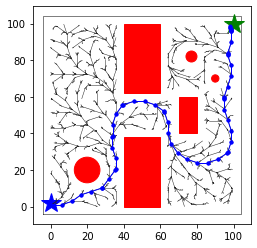

In [66]:
nmax = 50000

#goal region
xg=100
yg=100
epsilon=0
# vxmin = vymin = 0
# vxmax = xg
# vymax= yg
# thetadot_lim = 0.1
vinit = 5
winit = 0.1
xgmin=xg-epsilon
xgmax=xg+epsilon
ygmin=yg-epsilon
ygmax=yg+epsilon
rbot = 2

#extend step size
dmax = 10
del_t = 1
#start the root of the tree
nstart =(0,1,0) 
n_rect_obst = 3
wrad = 1

#specify vertices for rectangular obstacles (each object has four vertices)
#obstacles known a priori
v_origx= [40,40,60,60,70,70,80,80,40,40,60,60]
v_origy= [62,100,100,62,40,60,60,40, 0,38,38, 0]

centre_v = []
lw_v = []
w_list = []
rw_v = []

## Triangular obstacles

# after padding obstacles ########## FILL IN TRIANGLE COZ IDK HOW TO DO
vx = [i for i in v_origx]
vy = [i for i in v_origy]
for i in range(n_rect_obst):
    vx[i*4]-=2*rbot
    vx[i*4+1] -=2*rbot
    vx[i*4+2] +=2*rbot
    vx[i*4+3] +=2*rbot
    vy[i*4]-=2*rbot
    vy[i*4+3] -=2*rbot
    vy[i*4+1] +=2*rbot
    vy[i*4+2] +=2*rbot

#create an RRT tree with a start node
G = nonhn_RRT(nstart)

#environment instance
radii = [7+2*rbot,2+2*rbot, 3+2*rbot]
circle_x = [20,90,77]
circle_y = [20,70,82]
num_circles = len(circle_x)
E=env(vx,vy,radii,circle_x,circle_y,num_circles,0,100,0,100)

def main():
#     draw()
    for i in range(0,nmax):
        if i%10 ==0:
            print(i)
        G.expand_nh()
        
        if E.ingoal()==1:
            break
    G.path_to_goal()
    
    draw()
    


    
# run main when RRT is called
if __name__ == '__main__':
    main()

In [67]:
b = 1.5
lw_x = []
lw_y = []
rw_x = []
rw_y = []
centre_x = []
centre_y = []
theta_list = []
lw_x.append(nstart[0])
rw_x.append(nstart[0])
lw_y.append(nstart[1]+b)
rw_y.append(nstart[1]-b)
centre_x.append(nstart[0])
centre_y.append(nstart[1])
theta_list.append(nstart[2])
lw_v = []
rw_v = []

def visualize_nh_wheels(vc,wc):
    for i in range(len(wc)):

        lw_v.append(vc[i]-b*wc[i])
        rw_v.append(vc[i]+b*wc[i])

    for i in range(len(lw_v)):
        theta_cur = theta_list[-1]+wc[i]*del_t
 
        centre_x_cur = centre_x[-1]+vc[i]*del_t*np.cos(theta_cur)
        centre_y_cur = centre_y[-1]+vc[i]*del_t*np.sin(theta_cur)
        lw_x_cur = centre_x_cur - b*np.sin(theta_cur)
        lw_y_cur = centre_y_cur + b**np.cos(theta_cur)
        rw_x_cur = centre_x_cur + b*np.sin(theta_cur)
        rw_y_cur = centre_y_cur - b*np.cos(theta_cur) 
        
#         print (math.sqrt((rw_x_cur-lw_x_cur)**2+(rw_y_cur-lw_y_cur)**2))
        theta_list.append(theta_cur)
        lw_x.append(lw_x_cur)
        rw_x.append(rw_x_cur)
        lw_y.append(lw_y_cur)
        rw_y.append(rw_y_cur)
        centre_x.append(centre_x_cur)
        centre_y.append(centre_y_cur)
        
    for j in range(len(lw_y)):
        plt.plot([0-2*rbot,0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot],[0-2*rbot,100+2*rbot,100+2*rbot,0-2*rbot,0-2*rbot],'k',lw=0.5)

        plt.plot(xg,yg,'g*',markersize=20)

        num = len(E.obst_x)/4
        for i in range(1,int(num)+1): # Plotting rectangles
            x = E.obst_x[4*(i-1)] +2*rbot
            y = E.obst_y[4*(i-1)]+2*rbot
            width = E.obst_x[4*(i-1)+2] - E.obst_x[4*(i-1)] - 4*rbot
            height = E.obst_y[4*(i-1)+2] - E.obst_y[4*(i-1)] - 4*rbot
            rect = plt.Rectangle((x,y),width,height,linewidth=1,color='r')
            plt.gca().add_patch(rect)
#             plt.plot([E.obst_x[4*(i-1)],E.obst_x[4*(i-1)+1],E.obst_x[4*(i-1)+2],
#             E.obst_x[4*(i-1)+3],E.obst_x[4*(i-1)]],[E.obst_y[4*(i-1)],E.obst_y[4*(i-1)+1],
#             E.obst_y[4*(i-1)+2],E.obst_y[4*(i-1)+3],E.obst_y[4*(i-1)]],'k',lw=1)
# Uncomment to viz config space

        for i in range(E.num_circles):
            circle = plt.Circle((E.circle_x[i],E.circle_y[i]),E.radii[i]-2*rbot, color='r')
            plt.gca().add_patch(circle)
#             circle = plt.Circle((E.circle_x[i],E.circle_y[i]),E.radii[i], facecolor='none',linewidth=1,edgecolor='k')
#             plt.gca().add_patch(circle)
# Uncomment to viz config space
        plt.plot(lw_x[:j],lw_y[:j],'r--')
        plt.plot(rw_x[:j],rw_y[:j],'b--')
        plt.plot(centre_x[:j],centre_y[:j],'k-')
        colors = ['red', 'blue']
        lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
        labels = ['left wheel', 'right wheel']
        plt.legend(lines, labels)
        
        plt.gca().set_aspect('equal', adjustable='box')
#         plt.show()
        name = 'nh_wheel_data/snap%s.png'%str(j)
        plt.savefig(name, dpi = 200)
    
    
    
    
    

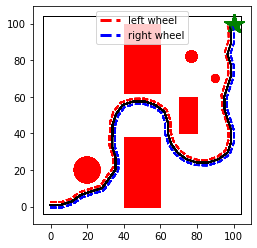

In [68]:
visualize_nh_wheels(centre_v,w_list)

In [69]:
# from moviepy.editor import VideoFileClip, concatenate_videoclips


# clip_1 = VideoFileClip("results/nh_simulation1.mp4")
# clip_2 = VideoFileClip("results/nh_simulation2.mp4")
# final_clip = concatenate_videoclips([clip_1,clip_2])
# final_clip.write_videofile("results/nh_final.mp4")

t:   3%|▎         | 13/433 [00:00<00:03, 121.15it/s, now=None]

Moviepy - Building video results/nh_final.mp4.
Moviepy - Writing video results/nh_final.mp4



Moviepy - Done !
Moviepy - video ready results/nh_final.mp4


w1_x = self.x[n2]+rbot*np.cos(self.theta[n2])
w1_y = self.y[n2]+rbot*np.sin(self.theta[n2])

w2_x = self.x[n2]+rbot*np.cos(self.theta[n2]+2*np.pi/3)
w2_y = self.y[n2]+rbot*np.sin(self.theta[n2]+2*np.pi/3)
w3_x = self.x[n2]+rbot*np.cos(self.theta[n2]+4*np.pi/3)
w3_y = self.y[n2]+rbot*np.sin(self.theta[n2]+4*np.pi/3)

$ wheel1x = centerx + radiusofbot*cos(\theta_{current})$

$ wheel1y = centery + radiusofbot*sin(\theta_{current})$

$ wheel2x = centerx + radiusofbot*cos(\theta_{current} + 2*\pi/3)$

$ wheel2y = centery + radiusofbot*sin(\theta_{current} + 2*\pi/3)$

$ wheel3x = centerx + radiusofbot*cos(\theta_{current} + 4*\pi/3)$

$ wheel3y = centery + radiusofbot*sin(\theta_{current} + 4*\pi/3)$